#### 원저자의 cost 함수를 수정함 maximize p(x|z) 대신 minimize MSE 사용: lib.models_varia
#### 원저자의 cost 함수는 lib.models

#####  missing values 로 mask 되어있는 hat_Values만 선택되어 mse 및 map 가 적용됨

In [1]:
import sys
import os
import time
from datetime import datetime
import numpy as np
import tensorflow as tf
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from absl import app
from absl import flags
sys.path.append("..")
from lib.models_varia_mse_y import *

# Enable mixed precision for performance
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt

outdir = './Results/HIVAE_newver2/'
# DATA = np.load("../../2.ProcessedData/mimic_30s_sample.npy")
checkpoint_prefix = os.path.join(outdir, "ckpt")

data_type = 'hmnist'
testing = False
num_steps = 0 # 'Number of training steps: If non-zero it overwrites num_epochs'
num_epochs = 10000
batch_size = 1500
print_interval = 0
TrRate = 0.8
LatDim = 10
learning_rate = 0.001

C:\Users\USER\anaconda3\envs\ai\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


### Data load

In [2]:
Data = np.load("D:/Dropbox/AICleansing_ver2/2.ProcessedData/train_mimic_orgscale.npy")
# ValData = np.load("D:/Dropbox/AICleansing_ver2/2.ProcessedData/valid_vitaldb_orgscale.npy")
data_len = len(Data)
np.random.shuffle(Data)
TrData = Data[data_len//5:]
ValData = Data[:data_len//5]
print(TrData.shape, ValData.shape)

(283380, 3000) (70844, 3000)


### Data processing

In [3]:
#Ver2

TrDataFrame = tf.signal.frame(TrData.astype('float32'), 50, 50).numpy()
ValDataFrame = tf.signal.frame(ValData.astype('float32'), 50, 50).numpy()

# np.random.shuffle(TrDataFrame)
# np.random.shuffle(ValDataFrame)

m_train_miss = np.random.choice([1,0], size=TrDataFrame.shape, p=[0.1,0.9])
m_val_miss = np.random.choice([1,0], size=ValDataFrame.shape, p=[0.1,0.9])

Tr_X = TrDataFrame.copy()
Tr_Y = (TrDataFrame - 20.0) / (220.0 - 20.0)
# 평균 80, 표준 편차 25인 정규 분포에서 값을 뽑아서 채울 배열 생성
random_values = np.random.normal(loc=80, scale=25, size=TrDataFrame.shape)
# m_train_miss가 1인 위치에 뽑은 값을 할당
Tr_X[m_train_miss == 1] = random_values[m_train_miss == 1]
Tr_X = (Tr_X - 20.0) / (220.0 - 20.0)

m_train_miss[:,-10:,:] = 1
Tr_X[:,-10:,:] = Tr_X[:,-10:,:] + np.random.normal(loc=0.0, scale=0.05, size=Tr_X[:,-10:,:].shape)

Tr_X = np.clip(Tr_X, 0.0, 1.0)

Val_X = ValDataFrame.copy()
Val_Y = (ValDataFrame - 20.0) / (220.0 - 20.0)
# 평균 80, 표준 편차 25인 정규 분포에서 값을 뽑아서 채울 배열 생성
random_values = np.random.normal(loc=80, scale=25, size=ValDataFrame.shape)
# m_train_miss가 1인 위치에 뽑은 값을 할당
Val_X[m_val_miss == 1] = random_values[m_val_miss == 1]
Val_X = (Val_X - 20.0) / (220.0 - 20.0)

m_val_miss[:,-10:,:] = 1
Val_X[:,-10:,:] = Val_X[:,-10:,:] + np.random.normal(loc=0.0, scale=0.05, size=Val_X[:,-10:,:].shape)

Val_X = np.clip(Val_X, 0.0, 1.0)

data_dim = TrDataFrame.shape[-1]
time_length = TrDataFrame.shape[1]
tr_sig_nb = len(TrDataFrame)

del random_values
del TrDataFrame
del ValDataFrame

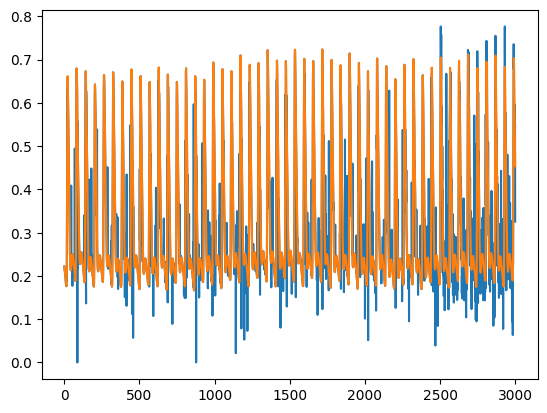

In [4]:
plt.plot(Tr_X[0].ravel())
plt.plot(Tr_Y[0].ravel())

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf_x_train_miss = (
    tf.data.Dataset.from_tensor_slices((Tr_X, Tr_Y, m_train_miss))
    .shuffle(tr_sig_nb)
    .batch(batch_size)
    .repeat()
    .prefetch(AUTOTUNE)  # Add prefetching.
)


### Model build

In [6]:
encoder = JointEncoderGRU
decoder = GaussianDecoder

model = HI_VAE(latent_dim=LatDim, data_dim=data_dim, time_length=time_length,
               encoder_sizes=[100, 80, 60], encoder=encoder,
               decoder_sizes=[60,80,100], decoder=decoder,
               M=1, K=1)

In [7]:
_ = tf.compat.v1.train.get_or_create_global_step()
trainable_vars = model.get_trainable_vars()
# optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

print("Encoder: ", model.encoder.net.summary())
print("Decoder: ", model.decoder.net.summary())

# For global step
global_step = tf.Variable(0, trainable=False)

gradient_clip = 1e4

# Initialize optimizer and learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Checkpoints
checkpoint = {
    "optimizer": optimizer,
    "encoder": model.encoder.net,
    "decoder": model.decoder.net,
    "global_step": global_step
}

if model.preprocessor is not None:
    print("Preprocessor: ", model.preprocessor.net.summary())
    checkpoint["preprocessor"] = model.preprocessor.net

saver = tf.train.Checkpoint(**checkpoint)

# TensorBoard
summary_writer = tf.summary.create_file_writer(outdir+'log/', flush_millis=10000)

# Compute steps and intervals
if num_steps == 0:
    num_steps = num_epochs * tr_sig_nb // batch_size
else:
    num_steps = num_steps

if print_interval == 0:
    print_interval = num_steps // num_epochs

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (1, 60, 100)              45600     
_________________________________________________________________
dense (Dense)                (1, 60, 80)               8080      
_________________________________________________________________
dense_1 (Dense)              (1, 60, 60)               4860      
_________________________________________________________________
dense_2 (Dense)              (1, 60, 20)               1220      
Total params: 59,760
Trainable params: 59,760
Non-trainable params: 0
_________________________________________________________________
Encoder:  None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (1, 60, 60)               660       
_______________

### Load weights

In [8]:
# model.encoder.net.load_weights(outdir+'encoder2.hdf5')
# model.decoder.net.load_weights(outdir+'decoder2.hdf5')

### Training 

In [9]:

# Function for a single training step
@tf.function
def train_step(x_seq, y_seq, m_seq, model, optimizer):
    with tf.GradientTape() as tape:
        loss = model.compute_loss(x_seq, y_seq, m_mask=m_seq)
    gradients = tape.gradient(loss, model.trainable_variables)
    # Gradient Clipping
    clipped_grads = [tf.clip_by_value(grad, -gradient_clip, gradient_clip) for grad in gradients]
    optimizer.apply_gradients(zip(clipped_grads, model.trainable_variables))
    return loss

# To store losses
losses_train = []
losses_val = []

# For best model saving
val_loss_check = 0.001

t0 = time.time()

# For TensorBoard visualization
summary_writer = tf.summary.create_file_writer("/path/to/log_dir")

with summary_writer.as_default():
    for i, (x_seq, y_seq, m_seq) in enumerate(tf_x_train_miss.take(num_steps)):
        loss = train_step(x_seq, y_seq, m_seq, model, optimizer)
        losses_train.append(loss.numpy())

        if i % print_interval == 0:
            print("================================================")
            print("Learning rate: {} | Global gradient norm: {:.2f}".format(
                optimizer._decayed_lr('float32'), 
                tf.linalg.global_norm(model.trainable_variables))
            )
            print("Step {}) Time = {:2f}".format(i, time.time() - t0))
            loss, mse, kl = model.compute_loss(x_seq, y_seq, m_mask=m_seq, return_parts=True)
            print("Train loss = {:.5f} | mse = {:.5f} | KL = {:.5f}".format(loss, mse, kl))
            
            tf.summary.scalar("loss_train", loss, step=i)
            tf.summary.scalar("kl_train", kl, step=i)
            tf.summary.scalar("mse_train", mse, step=i)

            # Validation
            random_indices = np.random.choice(len(Val_X), size=batch_size, replace=False)
            random_batch_X = Val_X[random_indices]
            random_batch_Y = Val_Y[random_indices]
            random_batch_m = m_val_miss[random_indices]
            val_loss, val_mse, val_kl = model.compute_loss(random_batch_X, random_batch_Y, m_mask=random_batch_m, return_parts=True)
            losses_val.append(val_loss.numpy())
            
            print("Validation loss = {:.5f} | mse = {:.5f} | KL = {:.5f}".format(val_loss, val_mse, val_kl))

            tf.summary.scalar("loss_val", val_loss, step=i)
            tf.summary.scalar("kl_val", val_kl, step=i)
            tf.summary.scalar("mse_val", val_mse, step=i)

            if val_loss_check > val_loss:
                val_loss_check = val_loss
                model.encoder.net.save_weights(outdir+'encoder_hivae_val'+str(val_loss.numpy())+'_valmse'+str(val_mse.numpy())+'.hdf5')
                model.decoder.net.save_weights(outdir+'decoder_hivae_val'+str(val_loss.numpy())+'_valmse'+str(val_mse.numpy())+'.hdf5')
#                 # Stop training if val_mse goes below 0.00043
#                 if val_mse < 0.00043:
#                     print("Stopping training as val_mse reached below 0.00043.")
#                     break

            t0 = time.time()


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0.,

KeyboardInterrupt: 

Learning rate: 0.00078568299068138 | Global gradient norm: 127.05
Step 22892) Time = 586.584012
Train loss = 0.00203 | mse = 0.00134 | KL = 0.00069
Validation loss = 0.00184 | mse = 0.00117 | KL = 0.00067
Learning rate: 0.0007837318116798997 | Global gradient norm: 127.10
Step 23128) Time = 584.468661
Train loss = 0.00134 | mse = 0.00066 | KL = 0.00068
Validation loss = 0.00118 | mse = 0.00051 | KL = 0.00067
Learning rate: 0.0007817854639142752 | Global gradient norm: 127.15
Step 23364) Time = 585.365923
Train loss = 0.00136 | mse = 0.00068 | KL = 0.00068
Validation loss = 0.00117 | mse = 0.00050 | KL = 0.00067
Learning rate: 0.0007798439473845065 | Global gradient norm: 127.21
Step 23600) Time = 584.075753
Train loss = 0.00132 | mse = 0.00064 | KL = 0.00068
Validation loss = 0.00114 | mse = 0.00047 | KL = 0.00067
Learning rate: 0.0007779072620905936 | Global gradient norm: 127.27
Step 23836) Time = 580.405240
Train loss = 0.00132 | mse = 0.00064 | KL = 0.00068
Validation loss = 0.0011

Train loss = 0.00132 | mse = 0.00064 | KL = 0.00067
Validation loss = 0.00114 | mse = 0.00047 | KL = 0.00066
Learning rate: 0.0007237881072796881 | Global gradient norm: 128.82
Step 30680) Time = 603.148640
Train loss = 0.00132 | mse = 0.00064 | KL = 0.00068
Validation loss = 0.00115 | mse = 0.00048 | KL = 0.00067
Learning rate: 0.0007219905382953584 | Global gradient norm: 128.87
Step 30916) Time = 556.050590
Train loss = 0.00131 | mse = 0.00064 | KL = 0.00067
Validation loss = 0.00113 | mse = 0.00047 | KL = 0.00066
Learning rate: 0.0007201976259239018 | Global gradient norm: 128.92
Step 31152) Time = 547.728974
Train loss = 0.00131 | mse = 0.00063 | KL = 0.00067
Validation loss = 0.00113 | mse = 0.00046 | KL = 0.00066
Learning rate: 0.0007184090791270137 | Global gradient norm: 128.98
Step 31388) Time = 548.024381
Train loss = 0.00136 | mse = 0.00069 | KL = 0.00067
Validation loss = 0.00119 | mse = 0.00053 | KL = 0.00066
Learning rate: 0.000716624956112355 | Global gradient norm: 129